# Анализ статистики продаж компьютерных игр.

**Описание проекта**
Вы работаете в компании, которая осуществляет продажу компьютерных игр через интернет-магазин и в сети офлайн магазинов. Одно из ключевых преимуществ компании — это анализ данных при планировании закупок и рекламных компаний. Ваша задача проанализировать накопленные данные о продажах в разные года, определить тренды и проверить гипотезы. Ваш основной результат — итоговая рекомендация руководству компании о том, на каких играх стоит сосредоточиться в будущем году.
***
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Источники данных**
собственная статистика продаж компании
'/datasets/games_data.csv'
'/datasets/rating.csv'

**Описание данных**
platform — платформа
sales_year — год продажи
genre — жанр игры
online — количество продаж (в сотнях тысяч)
offline — количество продаж (в сотнях тысяч)
critic_score — оценка критиков (максимум 100)
user_score — оценка пользователей (максимум 10)
rating — возрастной рейтинг ESRB
game_id — id игры

## Шаг 1. Загрузка исходных данных и визуальная оценка

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 

# настройка окружения
pd.options.display.max_columns = None
pd.options.display.float_format = '{0:.2f}'.format
sns.set()
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

In [2]:
# загрузка исходного датасета и первичная оценка данных
df_games = pd.read_csv('/datasets/games_data.csv')
df_esrb = pd.read_csv('/datasets/rating.csv') # данные о возрастном рейтинге ESRB

display(df_games.head())  
display(df_esrb)

,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id
0,PS3,2017.00,Action,702.00,909.00,97.00,8.2,M,20838
1,X360,2017.00,Action,966.00,514.00,97.00,8.1,M,48673
2,X360,2017.00,Shooter,904.00,424.00,88.00,3.4,M,17801
3,PS4,2015.00,Shooter,603.00,586.00,nan,NaN,NaN,12200
4,3DS,2017.00,Role-Playing,528.00,419.00,nan,NaN,NaN,11432


,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


## Шаг 2. Подготовка данных
Посчитайте общее количество продаж и запишите в отдельный столбец.
***
Приведите данные к нужным типам:
Опишите, в каких столбцах пришлось заменить тип данных и почему
***
Обработайте пропуски при необходимости:
Если вы решили заполнить пропуски определённым образом или не заполнять совсем — объясните, почему;
Опишите возможные причины возникновения пропусков;
Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать

In [3]:
# проверка типа данных в исходной таблице
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4026 entries, 0 to 4025
Data columns (total 9 columns):
platform        4026 non-null object
sales_year      4026 non-null float64
genre           4026 non-null object
online          4026 non-null float64
offline         4026 non-null float64
critic_score    1812 non-null float64
user_score      2382 non-null object
rating          2315 non-null object
game_id         4026 non-null int64
dtypes: float64(4), int64(1), object(4)
memory usage: 283.2+ KB


Типу 'object' соответствуют столбцы с категориальными данными и рейтинг пользователей 'user_score'.
Значит есть проблема с типом данных или содержимым. Проверяем структуру значений для столбцов dtype = 'object':

In [4]:
df_games.describe(include = ['object'])

,platform,genre,user_score,rating
count,4026,4026,2382,2315
unique,12,12,87,6
top,PS3,Action,tbd,M
freq,708,1270,350,622


**В 'user_score' имеется 350 записей со строковым значением 'tbd'. В данном контексте TBD = to be determined (будет определено позднее). Для данного иследования это означает отсутствие рейтинга на данный момент, выполняем преобразование данных в числовой формат и заменяем значения 'tbd' на 'NaN', чтобы иметь возможность проводить статистическую обработку данных.**

**'sales_year','online', 'offline'** - Выполняем преобразование столбцов с годом, числом продаж и экспертным рейтингом в целочисленный формат. Число проданных игр и год не могут быть дробными. Преобразование в данном случае целесообразно для удобства представления данных, а для больших объемов данных также даст скорость обработки и экономию места хранения.

In [5]:
# преоброзование столбцов в формат 'int'
for column in ['sales_year', 'online', 'offline']:
    df_games[column] = df_games[column].astype('int', errors = 'ignore')  

In [6]:
# добавление столбца 'total_sales' и подсчет общих продаж
df_games['total_sales'] = df_games['online'] + df_games['offline']

In [7]:
# замена значений 'tbd' на NaN в столбце 'user_score'
df_games['user_score'].replace('tbd', np.nan, inplace = True)

# преобразование столбца 'user_score' в числовой формат
df_games['user_score'] = df_games['user_score'].astype('float', errors='ignore')

# проверка
df_games.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4026 entries, 0 to 4025
Data columns (total 10 columns):
platform        4026 non-null object
sales_year      4026 non-null int64
genre           4026 non-null object
online          4026 non-null int64
offline         4026 non-null int64
critic_score    1812 non-null float64
user_score      2032 non-null float64
rating          2315 non-null object
game_id         4026 non-null int64
total_sales     4026 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 314.7+ KB


In [8]:
# проверка таблицы на дубликаты
df_games.duplicated().sum()
# Дубликаты отсутствуют

0

In [9]:
# проверка стлбца 'game_id' на уникальность значений 
# (если все значения уникальны результат должен быть равен нулю):
df_games['game_id'].shape[0] - df_games['game_id'].unique().shape[0]
# 190 значений повторяются. id не уникальны.

190

**Вывод: Данные подготовлены к дальнейшему анализу. Выполнены необходимые преобразования типов данных. Дубликаты не выявлены. 
Сокращение  'tbd' в 'user_score' заменено на 'NaN'. В столбце 'game_id' номера не являются уникальными, кроме id идентификация игр должна производиться и по другим столбцам (жанр и платформа)**

## Шаг 3. Исследовательский анализ данных

1. Постройте распределение количества игр по годам продажи и опишите полученный результат
2. Постройте распределение по годам продажи для игр с отзывом и без отзыва; cравните полученные распределения и сделайте вывод
3. Постройте график продаж по каждому году; сделайте вывод
4. Постройте ящик с усами по общим продажам, опишите полученный результат
5. Узнайте, на какой платформе было продано больше всего игр
6. Определите, игр какого жанра больше всего
7. Найдите игры с наибольшей и наименьшей оценкой от пользователей
8. Найдите игры с наибольшей и наименьшей оценкой от критиков
9. Оцените корреляцию между оценками критиков и пользовательскими оценками.

#### Распределение количества игр по годам продажи

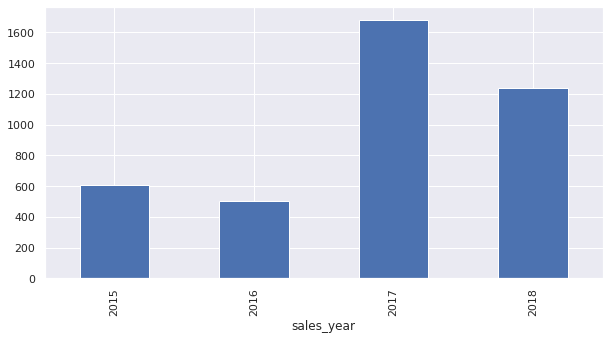

In [10]:
# Распределение количества игр по годам продажи 
(df_games
     .groupby('sales_year')['game_id']
     .count().plot(kind='bar', grid=True, figsize=(10,5))
);

**Вывод:** количество игр достигло максимума в 2017г.: 1700 игр против 600 в 2015г. 
В 2018 произошло небольшое снижение количества игр - до 1200.

#### Распределение объема продаж по годам 

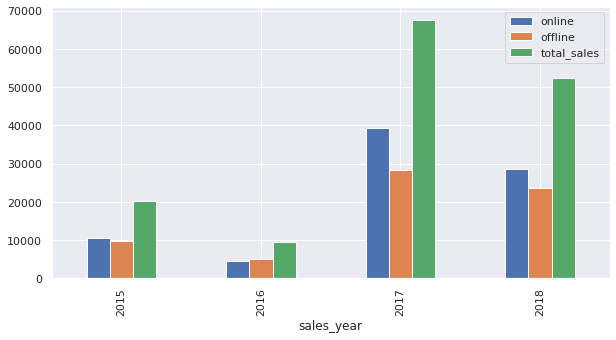

In [11]:
# Распределение объема продаж по годам
(df_games
     .groupby('sales_year')['online', 'offline', 'total_sales']
     .sum().plot(kind='bar', grid=True, figsize=(10,5))
);

**Вывод:** Есть тенденция к увеличению объемов продаж, но их динамика скачкообразна. В 2016 было двукратное падение объема продаж по отношению к 2015г: с 20 млн. до 10 млн., затем в 2017 - почти 7 кратный скачок до 68 илн. Затем, в 2018г., вновь спад до 52 млн. С 2017г объем онлайн продаж превышает продажи оффлайн, до этого момента они были практически равны.
***
**Гистограмма продаж похожа на гистограмму количества игр.**

#### Распределение  объема продаж по годам для игр с отзывом и без отзыва

sales_year
2015   28.08
2016   16.65
2017   13.32
2018   14.72
dtype: float64

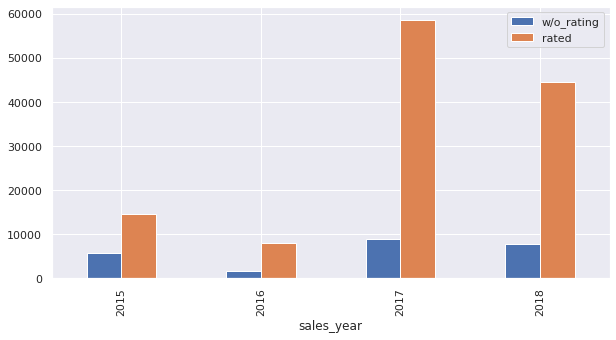

In [12]:
# Распределение объема продаж по годам для игр с отзывом и без отзыва
df_rating = pd.concat(
    [df_games.loc[df_games['rating'].isna() == True].groupby('sales_year')['total_sales'].sum(),
    df_games.loc[df_games['rating'].isna() == False].groupby('sales_year')['total_sales'].sum()],
    axis=1)
df_rating.columns = ['w/o_rating' , 'rated']
df_rating.plot(kind='bar', grid=True, figsize=(10,5))
df_rating['w/o_rating'] / (df_rating['rated'] + df_rating['w/o_rating']) * 100 # доля игр без рейтинга к общему количеству в %

**Вывод:** Наибольшая доля продаваемых игр без рейтинга была в 2015 г. - 28%, с 2016 их доля снизилась и находится в диапазоне 13 - 17% от общего количества. 

#### "Ящик с усами" по объему общих продаж

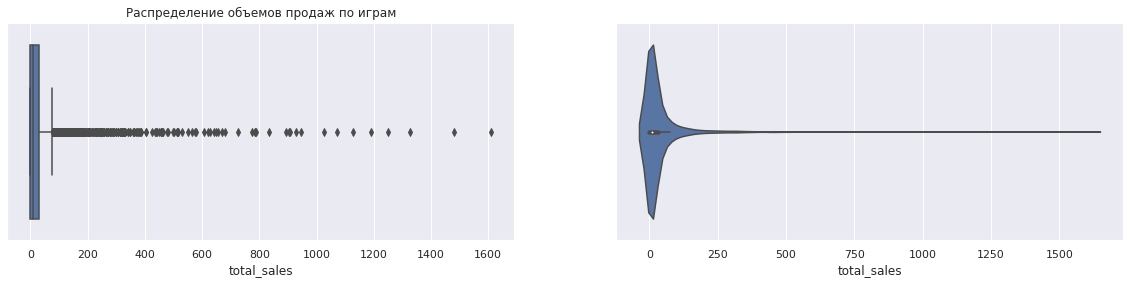

In [13]:
# для данных по объему продаж строим классический boxplot и вариант "виолончель" отражающий распределение частот
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 4))
sns.boxplot(df_games['total_sales'], ax=axes[0])
sns.violinplot(df_games['total_sales'], ax=axes[1])
axes[0].set_title('Распределение объемов продаж по играм');

**Вывод:** 75% игр имеют продажи до 100 тысяч экземпляров, при этом есть игры продажи которых исчисляются миллионами экзепляров.

#### На какой платформе было продано больше всего игр?

In [14]:
df_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(3)

platform
X360    34384
PS3     33130
PS4     24979
Name: total_sales, dtype: int64

**Вывод:** по объемам продаж лидируют игры для платформы X360 - 34 384 тыс.шт., с небольшим отрывом идет PS3 - 33 130 тыс.шт. и  третье место у PS4 - 24 979 тыс.шт.

#### Игр какого жанра больше всего

In [15]:
df_games['genre'].value_counts().head()

Action          1270
Role-Playing     467
Adventure        410
Sports           389
Misc             375
Name: genre, dtype: int64

**Вывод:** с большим отрывом лидируют продажи игр жанра 'Action' - 1270 тыс.шт., второе место 'Role-Playing' - 467 тыс.шт., и завершают пятерку 'Adventure', 'Sports', 'Misc' с продажами 410, 389 и 375 тыс.шт. соответственно.

#### Игры с наибольшей и наименьшей оценкой от пользователей

In [16]:
display(df_games.sort_values(by='user_score', ascending=False).head())
df_games.sort_values(by='user_score', ascending=False, na_position='first').tail()

,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,total_sales
2348,PSV,2015,Adventure,0,3,86.00,9.30,M,38270,3
639,PC,2015,Role-Playing,21,46,93.00,9.30,M,12365,67
77,PS4,2015,Role-Playing,102,213,92.00,9.20,M,43575,315
339,XOne,2015,Role-Playing,69,50,91.00,9.20,M,10495,119
2277,PSV,2017,Adventure,4,4,83.00,9.20,M,27691,8


,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,total_sales
2321,X360,2017,Shooter,7,2,43.00,1.20,M,24620,9
3026,PS3,2017,Racing,2,1,13.00,1.00,M,28618,3
2695,DS,2017,Platform,6,0,nan,0.90,E,14384,6
1739,X360,2016,Sports,14,2,nan,0.70,E,28773,16
2118,PS3,2016,Sports,7,2,nan,0.20,E,23493,9


**Вывод:** По мнению пользователей лучшие игры (имеют равный рейтинг 9.3) это игра id-38270 в жанре Adventure на платформе PSV и id-12365 в жанре Role-Playing на платформе PС, худшая ( с рейтингом 0.2)- id-23493 в жанре Sports платформа PS3.
Все TOP-5 игр в пользовательском рейтинге имеют жанр или Adventure или Role-Playing.

#### Игры с наибольшей и наименьшей оценкой от критиков

In [17]:
display(df_games.sort_values(by='critic_score', ascending=False).head())
df_games.sort_values(by='critic_score', ascending=False, na_position='first').tail()

,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,total_sales
0,PS3,2017,Action,702,909,97.00,8.20,M,20838,1611
9,PS4,2018,Action,396,631,97.00,8.30,M,28618,1027
44,XOne,2018,Action,281,219,97.00,7.90,M,39055,500
1,X360,2017,Action,966,514,97.00,8.10,M,48673,1480
19,X360,2017,Role-Playing,505,279,96.00,8.40,M,29673,784


,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,total_sales
2121,X360,2017,Sports,8,3,21.00,5.00,T,18203,11
2415,XOne,2015,Sports,3,5,20.00,3.10,E,42977,8
2127,PS4,2015,Sports,4,6,19.00,3.40,E,12797,10
2812,X360,2017,Racing,4,1,19.00,1.30,M,11902,5
3026,PS3,2017,Racing,2,1,13.00,1.00,M,28618,3


**Вывод:** По мнению критиков лучшие игры (их 4 и они имеют одинаковый рейтинг 97) с id-20838, 28618, 39055, 48673, причем все указанные игры в жанре Action. Ни одна из игр TOP-5 не совпадает с играми из аналогичного пользовательского рейтинга.
Худшая игра (с рейтингом 1)- id-28618 в жанре Racing платформа PS3. Тут мнение критиков и пользователей почти совпадает, игра числится в худших и у пользователей.
И в пользовательском рейтинге и в рейтинге критиков худшие игры относятся к жанрам Sports и Racing.

#### Корреляция между оценками критиков и пользовательскими оценками.

In [18]:
print('Коэф. корреляции между оценками критиков и пользователей: {:.2f}'
      .format(df_games['user_score'].corr(df_games['critic_score'])))

Коэф. корреляции между оценками критиков и пользователей: 0.53


**Вывод:** коэффициент корреляции между оценками критиков и пользователей составляет - 0.53 - средний уровень положительной связи  (по шкале Чеддока средний уровень лежит в диапазоне 0.5 - 0.7). Уровнем связи такой силы можно пренебречь. Целесообразно рассматривать оценки пользователей и критиков отдельно.

## Шаг 4. Портрет пользователя для онлайн и офлайн продаж

Для покупателей интернет-магазина и сети розничных магазинов определите:
1. топ-5 предпочтительных жанров
2. в какие года пользователи были наиболее активны (больше всего покупали игры)
3. топ-5 предпочтительных платформ
4. какой рейтинг ESRB встречается чаще всего (наиболее частотная категория)

#### TOП-5  жанров для покупателей интернет-магазина и сети розничных магазинов 

In [19]:
print('ТОП-5 жанров в интернет магазине')
display(df_games.groupby('genre')['online'].sum().sort_values(ascending=False).head())
print('ТОП-5 жанров в сети розничных магазинов')
display(df_games.groupby('genre')['offline'].sum().sort_values(ascending=False).head())

ТОП-5 жанров в интернет магазине


genre
Action          23088
Shooter         19443
Sports          10866
Role-Playing     8377
Misc             6967
Name: online, dtype: int64

ТОП-5 жанров в сети розничных магазинов


genre
Action          19910
Shooter         14798
Sports           8847
Role-Playing     6229
Racing           4056
Name: offline, dtype: int64

**Вывод:** По обоим каналам продаж топовый рейтинг совпадает, это жанры: Action, Shooter, Sports, Role-Playing.
Пятое место отличается: Misc для интернет магазина, Racing в рознице.

#### В какие года пользователи были наиболее активны (больше всего покупали игры)
Вопрос повторяет вопрос предыдущего раздела об объемах продаж по годам. Ответ соответственно тот же:
**Вывод:** Есть тенденция к увеличению активности, но динамика скачкообразна. В 2016 было двукратное падение объема продаж по отношению к 2015г: с 20 млн. до 10 млн., затем в 2017 - почти 7 кратный скачок до 68 илн. Затем, в 2018г., вновь спад до 52 млн.

#### TOП-5 платформ для покупателей интернет-магазина и сети розничных магазинов 

In [20]:
print('ТОП-5 платформ в интернет магазине')
display(df_games.groupby('platform')['online'].sum().sort_values(ascending=False).head())
print('ТОП-5 платформ в сети розничных магазинов')
display(df_games.groupby('platform')['offline'].sum().sort_values(ascending=False).head())

ТОП-5 платформ в интернет магазине


platform
X360    22675
PS3     16823
PS4     10873
XOne     9312
3DS      8265
Name: online, dtype: int64

ТОП-5 платформ в сети розничных магазинов


platform
PS3     16307
PS4     14106
X360    11709
3DS      6126
PC       5669
Name: offline, dtype: int64

**Вывод:** Самая популярная платформа онлайн продаж - X360, оффлайн - PS3. 
TOP-3 платформы совпадают и для онлайн и оффлайн продаж, это: X360 и PS3, PS4. 
4-5 места в интернет магазине занимают платформы XOne и 3DS, в рознице 3DS и PC.

#### Какой рейтинг ESRB встречается чаще всего (наиболее частотная категория)

In [21]:
display(df_esrb)
df_games['rating'].value_counts(normalize=True) *100

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


M      26.87
E      26.74
T      26.61
E10+   19.70
EC      0.04
RP      0.04
Name: rating, dtype: float64

**Вывод:** 80% игр в равных долях (по 27%) имеют один из рейтингов: Е, М, Т (соответственно: Е - Для всех
, M - От 17 лет, T - Подросткам 13—19 лет). 19,7% приходится на игры с рейтингом E10+ - Для всех старше 10 лет. Распространение игр с остальными рейтингами ESRB близко к 0.

#### Распределение продаж по платформам и жанру (дополнительно)

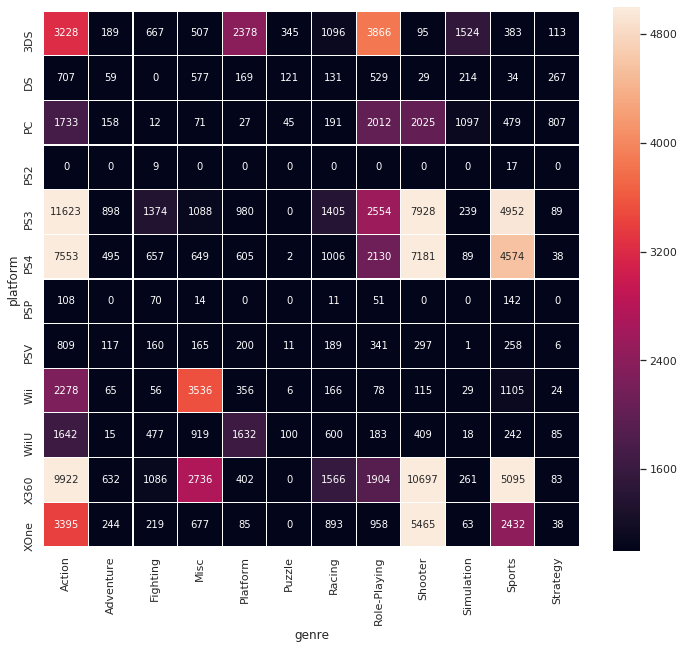

In [22]:
fig, axs=plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(df_games
            .pivot_table(index='platform', columns='genre', values='total_sales', aggfunc=sum).fillna(0), 
            annot=True, fmt=".0f", linewidths=.1, square=True , ax=axs, vmin=1000, vmax =5000);

**Вывод:** Есть выраженные лидеры популярности по платформам и жанрам, причем популярные жанры (Action, Shooter, Sports) совпадают для основных платформ (PS4, PC3, X360). Есть жанры популярность которых особенно выражена на отдельных платформах, своего рода "специализация": Misc для Wii и RolePlaying для 3DS.

## Шаг 5. Проверка гипотез

**Проверьте гипотезы:**
1. средний пользовательский рейтинг платформ PS2 и PS3 одинаковый;
2. средний пользовательский рейтинг жанров Action и Sports различается.
***
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

#### Сравнение пользовательского рейтинга платформ PS2 и PS3

**Гипотеза:**
***
**H0:** средний пользовательский рейтинг платформ PS2 и PS3 равны;
**H1:** средний пользовательский рейтинг платформ PS2 и PS3 различается.
***
Пороговое значение alpha = 0,05

Проверяем число записей доступных для анализа:

In [23]:
print('Количество игр имеющих рейтинг для PS2:',
df_games.loc[df_games['platform'] == 'PS2'].loc[df_games['user_score'].isnull() == False, 'user_score'].shape[0]
     )

Количество игр имеющих рейтинг для PS2: 3


In [24]:
print('Количество игр имеющих рейтинг для PS3:',
df_games.loc[df_games['platform'] == 'PS3'].loc[df_games['user_score'].isnull() == False, 'user_score'].shape[0]
     )

Количество игр имеющих рейтинг для PS3: 417


Для проверки гипотезы использум t-критерий Стьюдента для индивидуальных выборок:

In [25]:
# проверяем ряды по t-критерию Стьюдента
# нулевые значения пользовательского рейтинга при анализе отбрасываем
u, p_value = st.ttest_ind(
    df_games.loc[df_games['platform'] == 'PS2'].loc[df_games['user_score'].isnull() == False, 'user_score'], 
    df_games.loc[df_games['platform'] == 'PS3'].loc[df_games['user_score'].isnull() == False, 'user_score'],
    equal_var = True)
print('t-критерий Стьюдента:', u, ' Уровень значимости критерия:', p_value)

t-критерий Стьюдента: -0.7464554470149002  Уровень значимости критерия: 0.45581194981839523


**Вывод:** Расчетный уровень значимости t-критерия Стьюдента 45% при принятом пороговом значении 5%. Нулевая гипотеза не может быть отвергнута: **средний пользовательский рейтинг платформ PS2 и PS3 равны**.

#### Сравнение пользовательского рейтинга жанров Action и Sports

**Гипотеза:**
***
**H0:** средний пользовательский рейтинг жанров Action и Sports равны;
**H1:** средний пользовательский рейтинг жанров Action и Sports различается.
***
Пороговое значение alpha = 0,05

In [26]:
# тест д'Агостино на соответствие распределения нормальному
# ключ nan_policy='omit' игнорирует пропущенные значения в выборке при расчете
print('Тест д''Агостино на соответствие выборки нормальному закону распределения:')
print('Жанр Actions:', st.normaltest(df_games.loc[df_games['genre'] == 'Action'].user_score, nan_policy='omit'))
print('Жанр Sports:', st.normaltest(df_games.loc[df_games['genre'] == 'Sports'].user_score, nan_policy='omit'))

Тест дАгостино на соответствие выборки нормальному закону распределения:
Жанр Actions: NormaltestResult(statistic=89.63526239294482, pvalue=3.4351845940767393e-20)
Жанр Sports: NormaltestResult(statistic=17.021782939683874, pvalue=0.0002012643238392333)


Гипотеза о соответсвии выборок нормальному распределению не подтвердилась. 
Для проверки нулевой гипотезы использем критерий Манна-Уитни.

In [27]:
u, p_value = st.mannwhitneyu(
    df_games.loc[df_games['genre'] == 'Action'].loc[df_games['user_score'].isnull() == False, 'user_score'],
    df_games.loc[df_games['genre'] == 'Sports'].loc[df_games['user_score'].isnull() == False, 'user_score'])
print('U-критерий Манна — Уитни:', u, ' Уровень значимости критерия:', p_value)

U-критерий Манна — Уитни: 48232.5  Уровень значимости критерия: 1.0620319622580433e-21


**Вывод** Уровень значимости составил 1e-21 при пороговом 0.05, нулевую гипотезу отвергаем. Принимаем альтернативную гипотезу: **средний пользовательский рейтинг жанров Action и Sports различаются**.

## Шаг 6. Общий вывод

**Рейтинг игр составленный пользователями и составленный экспертами не имеют значимого уровня корреляции между собой (уровень 0.53). Топовые игры по мнению экспертов и по мнению пользователей также отличаются.
***
Динамика продаж имеет скачкообразный характер по годам, но в целом растет: с 20 млн. в 2015, до 52млн. в 2018. С 2017 года большая часть продаж идет через интернет магазин. Доля продаж для игр без рейтинга снижается и составила 15% в 2018г. 75% игр имеют продажи до 100 тысяч экземпляров, при этом есть игры продажи которых исчисляются миллионами экзепляров.
***
Самые популярные платформы для всех каналов продаж  X360, PS3, PS4. На самых популярных платформах самые востребованные жанры совпадают, это: Action, Shooter, Sports, Role-Playing. Если брать общую структуру продаж по всем платформам, то жанр Role-Playing будет на втором месте.
***
Выявлены жанры, популярность которых особенно выражена на отдельных платформах, своего рода "специализация": Misc для Wii и RolePlaying для 3DS.
***
Рейтинг ESRB: 80% игр в равных долях (по 27%) имеют один из рейтингов: Е, М, Т (соответственно: Е - Для всех
, M - От 17 лет, T - Подросткам 13—19 лет). 19,7% приходится на игры с рейтингом E10+ - Для всех старше 10 лет. Распространение игр с остальными рейтингами ESRB близко к 0.
***
Проверка гипотезы о равенстве среднего пользовательского рейтинга платформ PS2 и PS3  статистическими методами невозможна по предоставленному массиву данных.
***
Гипотеза о различии среднего пользовательского рейтинга жанров Action и Sports возможно верна.
***
**H0:** средний пользовательский рейтинг жанров Action и Sports равны;
**H1:** средний пользовательский рейтинг жанров Action и Sports различается.
Уровень значимости составил 1e-21 при пороговом 0.05, нулевая гипотеза отвергнута. 

#### Промежуточные выводы по разделам:

#### Шаг 3. Исследовательский анализ данных
***
1. Распределение количества игр по годам продажи 
**Вывод:** количество игр достигло максимума в 2017г.: 1700 игр против 600 в 2015г. 
В 2018 произошло небольшое снижение количества игр - до 1200.
***
2. Распределение по годам продажи для игр с отзывом и без отзыва
**Вывод:** Есть тенденция к увеличению объемов продаж, но их динамика скачкообразна. В 2016 было двукратное падение объема продаж по отношению к 2015г: с 20 млн. до 10 млн., затем в 2017 - почти 7 кратный скачок до 68 илн. Затем, в 2018г., вновь спад до 52 млн. С 2017г объем онлайн продаж превышает продажи оффлайн, до этого момента они были практически равны.
**Гистограмма продаж похожа на гистограмму количества игр.**
***
3. График продаж по каждому году
**Вывод:** Наибольшая доля продаваемых игр без рейтинга была в 2015 г. - 28%, с 2016 их доля снизилась и находится в диапазоне 13 - 17% от общего количества.
***
4. "Ящик с усами" по общим продажам
**Вывод:** 75% игр имеют продажи до 100 тысяч экземпляров, при этом есть игры продажи которых исчисляются миллионами экзепляров.
***
5. Платформа где было продано больше всего игр
**Вывод:** по объемам продаж лидируют игры для платформы X360 - 34 384 тыс.шт., с небольшим отрывом идет PS3 - 33 130 тыс.шт. и  третье место у PS4 - 24 979 тыс.шт.
***
6. Игр какого жанра больше всего?
**Вывод:** с большим отрывом лидируют продажи игр жанра 'Action' - 1270 тыс.шт., второе место 'Role-Playing' - 467 тыс.шт., и завершают пятерку 'Adventure', 'Sports', 'Misc' с продажами 410, 389 и 375 тыс.шт. соответственно.
***
7. Игры с наибольшей и наименьшей оценкой от пользователей
**Вывод:** По мнению пользователей лучшие игры (имеют равный рейтинг 9.3) это игра id-38270 в жанре Adventure на платформе PSV и id-12365 в жанре Role-Playing на платформе PС, худшая ( с рейтингом 0.2)- id-23493 в жанре Sports платформа PS3.
Все TOP-5 игр в пользовательском рейтинге имеют жанр или Adventure или Role-Playing.

8. Найдите игры с наибольшей и наименьшей оценкой от критиков
**Вывод:** По мнению критиков лучшие игры (их 4 и они имеют одинаковый рейтинг 97) с id-20838, 28618, 39055, 48673, причем все указанные игры в жанре Action. Ни одна из игр TOP-5 не совпадает с играми из аналогичного пользовательского рейтинга.
Худшая игра (с рейтингом 1)- id-28618 в жанре Racing платформа PS3. Тут мнение критиков и пользователей почти совпадает, игра числится в худших и у пользователей.
И в пользовательском рейтинге и в рейтинге критиков худшие игры относятся к жанрам Sports и Racing.
***
9. Оцените корреляцию между оценками критиков и пользовательскими оценками.
**Вывод:** коэффициент корреляции между оценками критиков и пользователей составляет - 0.53 - средний уровень положительной связи  (по шкале Чеддока средний уровень лежит в диапазоне 0.5 - 0.7). Уровнем связи такой силы можно пренебречь. Целесообразно рассматривать оценки пользователей и критиков отдельно.

#### Шаг 4. Портрет пользователя для онлайн и офлайн продаж¶
1. Топ-5 предпочтительных жанров
**Вывод:** По обоим каналам продаж топовый рейтинг совпадает, это жанры: Action, Shooter, Sports, Role-Playing.
Пятое место отличается: Misc для интернет магазина, Racing в рознице.

2. В какие года пользователи были наиболее активны (больше всего покупали игры)
Вопрос повторяет вопрос предыдущего раздела об объемах продаж по годам. Ответ соответственно тот же:
**Вывод:** Есть тенденция к увеличению активности, но динамика скачкообразна. В 2016 было двукратное падение объема продаж по отношению к 2015г: с 20 млн. до 10 млн., затем в 2017 - почти 7 кратный скачок до 68 илн. Затем, в 2018г., вновь спад до 52 млн.

3. Топ-5 предпочтительных платформ
**Вывод:** Самая популярная платформа онлайн продаж - X360, оффлайн - PS3. 
TOP-3 платформы совпадают и для онлайн и оффлайн продаж, это: X360 и PS3, PS4. 
4-5 места в интернет магазине занимают платформы XOne и 3DS, в рознице 3DS и PC.

4. Какой рейтинг ESRB встречается чаще всего (наиболее частотная категория)
**Вывод:** 80% игр в равных долях (по 27%) имеют один из рейтингов: Е, М, Т (соответственно: Е - Для всех
, M - От 17 лет, T - Подросткам 13—19 лет). 19,7% приходится на игры с рейтингом E10+ - Для всех старше 10 лет. Распространение игр с остальными рейтингами ESRB близко к 0.

5. Распределение продаж по платформам и жанру (дополнительно)
**Вывод:** Есть выраженные лидеры популярности по платформам и жанрам, причем популярные жанры (Action, Shooter, Sports) совпадают для основных платформ (PS4, PC3, X360). Есть жанры популярность которых особенно выражена на отдельных платформах, своего рода "специализация": Misc для Wii и RolePlaying для 3DS.

#### **Шаг 5. Проверка гипотез**
***
**1.	Средний пользовательский рейтинг платформ PS2 и PS3 одинаковый;**
**Гипотеза:**
***
**H0:** средний пользовательский рейтинг платформ PS2 и PS3 равны;
**H1:** средний пользовательский рейтинг платформ PS2 и PS3 различается.
***
**Вывод: Средний пользовательский рейтинг платформ PS2 и PS3 равны** Расчетный уровень значимости t-критерия Стьюдента 45% при принятом пороговом значении 5%. Нулевая гипотеза не может быть отвергнута.
***
**2. Средний пользовательский рейтинг жанров Action и Sports различается.**
**Гипотеза:**
***
**H0:** средний пользовательский рейтинг жанров Action и Sports равны;
**H1:** средний пользовательский рейтинг жанров Action и Sports различается.
***
**Вывод: Средний пользовательский рейтинг жанров Action и Sports различаются**
Уровень значимости составил 1e-21 при пороговом 0.05, нулевую гипотезу отвергаем. Принимаем альтернативную гипотезу Н1.